In [1]:
from IPython.display import display, Markdown as md
from IPython.display import display
from whr.imports import *

%load_ext autoreload
%autoreload 2
import whr
from whr import *

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
whr.setup_pytensor()

In [2]:
da = whr.PreprocessedData.load()

In [3]:
jointUnadjModel = whr.createUnadjustedCumsumMatrixModel(da).loadIData().loadMAP()
jointSimpleAdjModel = whr.createSimpleAdjustedModel(da).loadIData()
jointBPSTAdjModel = whr.createBPSTAdjustedModel(da).loadIData()

jointModels = dict(jointUnadjModel=jointUnadjModel,
                   jointSimpleAdjModel=jointSimpleAdjModel,
                   jointBPSTAdjModel=jointBPSTAdjModel)


In [4]:
unevenGamesData = da.restrictGames(da.games.winnerCount != da.games.loserCount, True)

# The fixed ratings used in the fixed-rating models
unevenGamesMAPRatings : pd.DataFrame = jointUnadjModel.MAP_ratings.loc[unevenGamesData.playerDays.index, 'rating']
unevenGamesMeanRatings = jointUnadjModel.getMeanRatingsForPlayerDays(unevenGamesData.playerDays.index)

In [5]:
frModels = whr.makeAllFixedRatingsModels(unevenGamesData, unevenGamesMeanRatings=unevenGamesMeanRatings, unevenGamesMAPRatings=unevenGamesMAPRatings)

for m in frModels.values(): m.loadIData()

In [ ]:
for m in list(jointModels.values())+list(frModels.values()):
    if not 'log_likelihood' in m.idata:
        with m.model:
            m.compute_log_likelihood()

Revisions:

v2 (2023-07-01)
: * Added missing games from Jan to April 2022 (thanks @malric for finding)
    * Disaggregated "8v9+" category into 8v9, 9v10, ... 15v16+ because the `epad` for 8v9+ was still clearly positive. It now looks like we can exclude a zero effect up to 10v11.

v1
: * Still available for comparision [here](posting1.html).

# The issue
When balancing Zero-K team games with an odd number of players, the current balancer tries to find two teams with the same *average* member rating, without taking team size into account (for example, it thinks that a team of a 2500 Elo player and a 1500 Elo player vs a single 2000 Elo player is 50%). I tried to find out how much of an advantage the larger team has, relative to the win rate predicted by WHR. The results indicate that the larger team does have a moderate advantage depending on team sizes and the exact model. Disclaimer: I'm using some of these tools for the first time.

These findings, if correct, could be used to:

1. Balance uneven team games more accurately.

2. When updating the ratings of the participants after the game, account for the team size effect. Everything else being equal, winning as a member of the small team is more surprising than winning as a member of the large team.

The following plots show the advantage of the larger team in terms of extra Elo equivalent (see below for the difference between the two models shown. In short, the "jointly fitted" model corresponds to doing both 1. and 2. above, whereas the "Ratings fixed" model takes the unmodified WHR ratings as given and only tries to improve the predictions relative to that.)

::: {.callout-note}
##

The plots represent Bayesian posterior probability densities; the probability that the value is in a given range is proportional to the shaded area over that range. The little circles are the means. 
:::

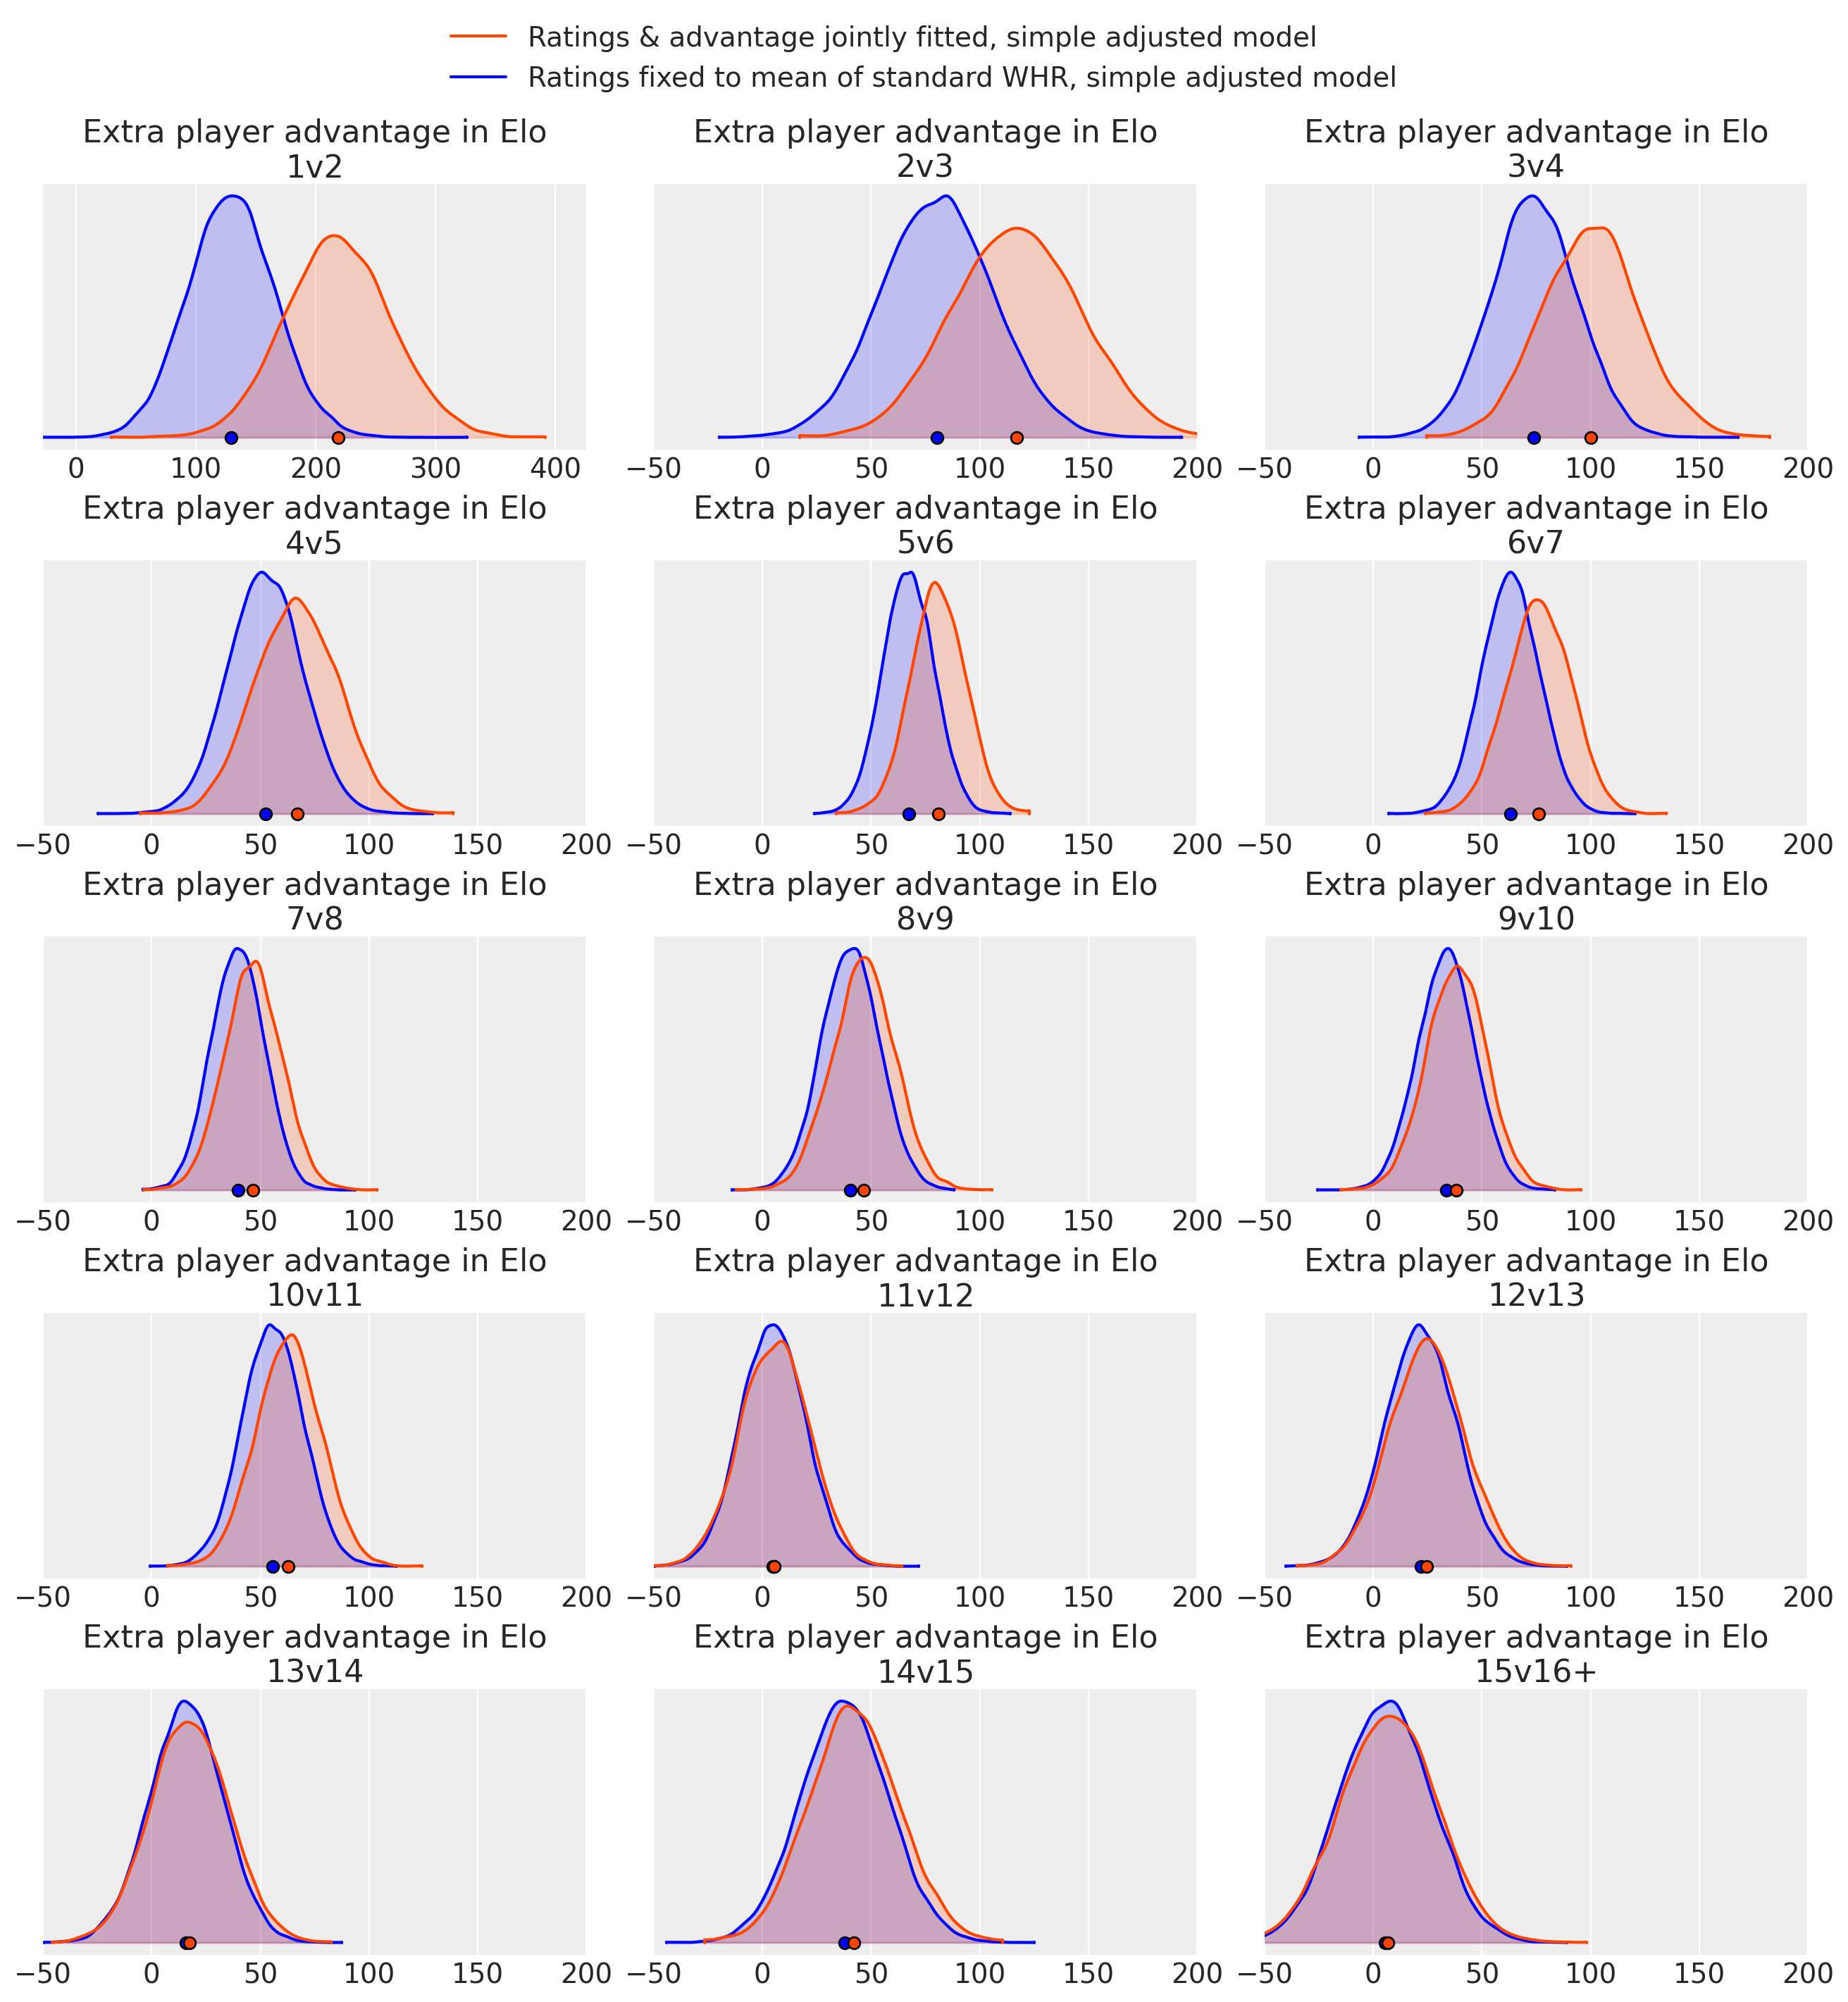

In [31]:
#| column: page
#| fig-cap: "Main result"
#| fig-label: fig-main-result
# fig-subcap: "fooooo"


axs = az.plot_density(
    [frModels['meanSimple'].epad_in_Elo(), jointSimpleAdjModel.epad_in_Elo(), ],
    data_labels=[frModels['meanSimple'].title(), jointSimpleAdjModel.title(), ],
    hdi_prob=1,
    figsize=(13,13.35),
    shade=0.2,
    point_estimate='mean',
    colors=['blue','orangered']
)

whr.postprocess.putLegendOnTopOfFigure(axs[0][0], (.5,1.0598))

for _, ax in np.ndenumerate(axs):
    if ax != axs[0][0]:
        ax.set_xlim(-50,200)

axs[0][0].set_xlim(-27.5,426)
pass

(Different x-axis scale for 1v2.)

We see that there's strong evidence that the advantage size is positive up to 10v11, but it is kind of disappointingly small for 2v3 to 4v5 (I expected higher).

Note though that these advantages are applied after the usual averaging of team members, so for example for 3v4, an advantage of 100 means that a game with Elos [1300, 1000, 1000] vs [1000, 1000, 1000, 1000] would be fair (50%).

I don't have a theory yet on why the effect is so much larger for the joint model at some sizes.


# Data
Thanks to @malric for providing the data on [Zero-K Local Analysis](https://zero-k.info/Forum/Thread/34840?page=1). I initially tried to include all casual-rated games, but then decided to use only games tagged `is_autohost_teams` and extend the time horizon instead (was reaching the limits of what my hardware can handle in reasonable time), so some of the following filters are probably redundant. I dropped games that:

 * were not tagged as teams autohost games
 * were noelo
 * were FFA (either tagged so, or having team_ids different from 1 and 2)
 * had chickens or bots or game mods
 * were shorter than 20 seconds
 * had no winners (exit?), or no losers somehow
 * had a player count difference of more than 1 (should be impossible on autohost)
 * were on a "special" map other than Dockside v2, which I heard actually isn't special.

The filtered dataset included 25813 games and 87236 PlayerDays from 2019 to May 2023, of which 8203 games were uneven-sized (a "PlayerDay" is a day, player pair on which that player played; WHR assigns a rating estimate to every PlayerDay). I actually downloaded the data back to 2017, but games from before 2019 aren't detected as teams autohost currently (may be addressed in a future revision).

I did not have access to the actual player rating histories, so "unmodified WHR" (in the previous section) means the ratings I inferred using the standard WHR model, using only this dataset.

Breakdown of uneven games in the dataset:

In [47]:
#| fig-cap: "Uneven game counts"
#| column: body-outset
#| label:  fig-game-counts
whr.createGameCountByBPSTSummaryTable(unevenGamesData, unevenGamesMeanRatings)

Rating of best player of small team → < 1800 Elo       [1800; 2200]        \
                                      ↓ winner ↓         ↓ winner ↓         
                                           Large Small        Large Small   
Size                                                                        
1v2                                           87    27           24    14   
2v3                                           80    30           57    40   
3v4                                           78    32          108    70   
4v5                                           48    20          105    82   
5v6                                           35    11          173    95   
6v7                                           15     5          126    84   
7v8                                           17     9          118    74   
8v9                                            5     4           70    46   
9v10                                           7     4           68    44   
10v11                                          2     0           44    24   
11v12                                          3     1           36    34   
12v13                                          1     0           17    13   
13v14                                          1     3            7    11   
14v15                                          0     0           10     6   
15v16+                                         0     0            5     6   

Rating of best player of small team → > 2200 Elo        
                                      ↓ winner ↓        
                                           Large Small  
Size                                                    
1v2                                            5     4  
2v3                                           19    16  
3v4                                           42    38  
4v5                                          122    97  
5v6                                          389   290  
6v7                                          336   223  
7v8                                          375   309  
8v9                                          339   280  
9v10                                         343   303  
10v11                                        335   259  
11v12                                        255   255  
12v13                                        235   212  
13v14                                        218   201  
14v15                                        164   137  
15v16+                                       138   128

# Models

If not already familiar with it, you might want to look at @sec-whr-like and [-@sec-whr-prior] for the standard (unadjusted) WHR model.

## Simple adjusted model
Since the rating averaging with no regard to team size seems wrong, I extended the model by introducing a new parameter which I called `epad` (extra player advantage), such that if team 1 has one more player than team 2, and if $r := \text{team 1 natural rating} - \text{team 2 natural rating}$:
$$P(\text{team 1 wins} | r) = \text{sigmoid}(r + \textbf{epad}) \equiv \frac{1}{1+\exp(-(r + \textbf{epad}))}$$
so the team with one more player is simply treated as if it had `epad` more rating than it actually has. Unadjusted WHR is the special case when `epad = 0`.

I expected the advantage size to be different for 1v2, 2v3 etc, so `epad` is actually an array of parameters, one for each uneven teams size[^bigGames] (as mentioned, games with a player count difference > 1 were dropped).

[^bigGames]: For historical games bigger than 15v16, I assumed: $P(\text{team 1 wins} | r) = \text{sigmoid}\left(r + \text{epad}_\text{15v16+} \cdot \frac{15}{\text{size of smaller team}}\right)$

I used a weakly informative prior for each epad:
$$\text{epad} \sim \text{Normal}(\text{mean} = 0, \text{sdev} = 1000 \text{ Elo})$$ 
which represents a belief like "I have no idea if the larger team has an advantage or a disadvantage, but the effect is probably less than 2000 Elo". (That's suppsosed to be a somewhat "objective" prior; my actual personal prior is that the effect is positive[^prior-corr]. While it's true that the larger team has no material advantage (other than more starting position choices), APM matters.)

[^prior-corr]: And that the `epad`s for different size games are somewhat correlated, whereas they are independent in the "objective" prior used here.

In [48]:
logging.disable(logging.INFO)
prior = pm.sample_prior_predictive(50000,frModels['mapSimple'].model,var_names=['epadc']).prior.epadc
logging.disable(logging.NOTSET)
prior.name = 'Prior for each `epad`'

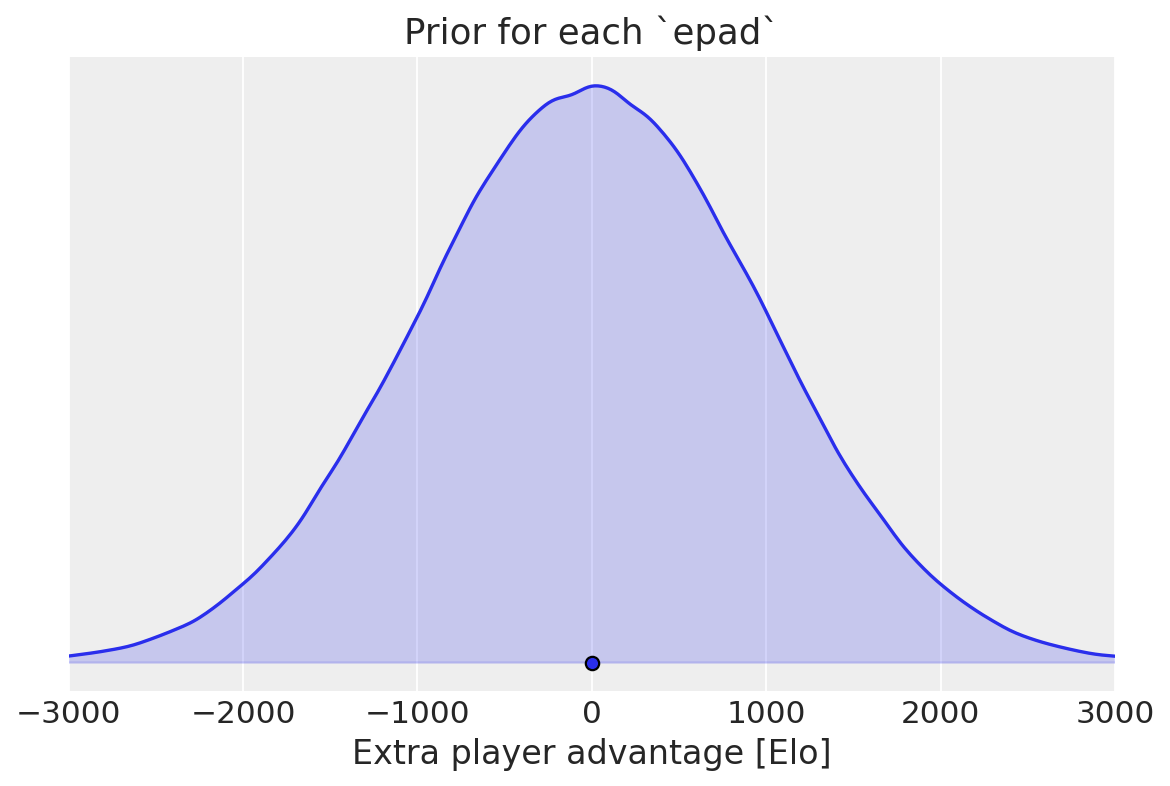

In [49]:
[[ax]] = az.plot_density(eloPerNaturalRating * prior, combine_dims={ 'advc' }, hdi_prob=1, shade=0.2)
ax.set_xlabel('Extra player advantage [Elo]')
ax.set_xlim(-3000,3000)
ax.figure.set_dpi(80)
pass

In [50]:
del prior


## Best Player of Smaller Team - dependent model
@Sprung plausibly suggested to discriminate by the rating of the Best Player of the Smaller Team (BPST), because they are the one with the double comm. In this second model, `epad` is a 2d array indexed by both team sizes and rating class, for which I used just "high rating" and "low rating" (I think the data would get too thin with more). I then used a smoothened version of `if BPST_Elo < 2000 then epad_low else epad_high` as follows. Let *b* be the Elo of the BPST, then define the "Rating highness" as:[The calculation of the "best" player rating actually uses a smooth approximation to `max`, to keep the model differentiable.]{.aside}

$$ \text{rh}(b) := \text{sigmoid}\left(\frac{b - 2000}{200}\right) $$
$$
  P(\text{team 1 wins } | r, b) = \text{sigmoid}\left( r + \text{rh}(b) \cdot \text{epad}_\text{high} + (1 - \text{rh}(b)) \cdot \text{epad}_\text{low} \right)
$$
The BPST model uses the same prior for each epad as the simple model.


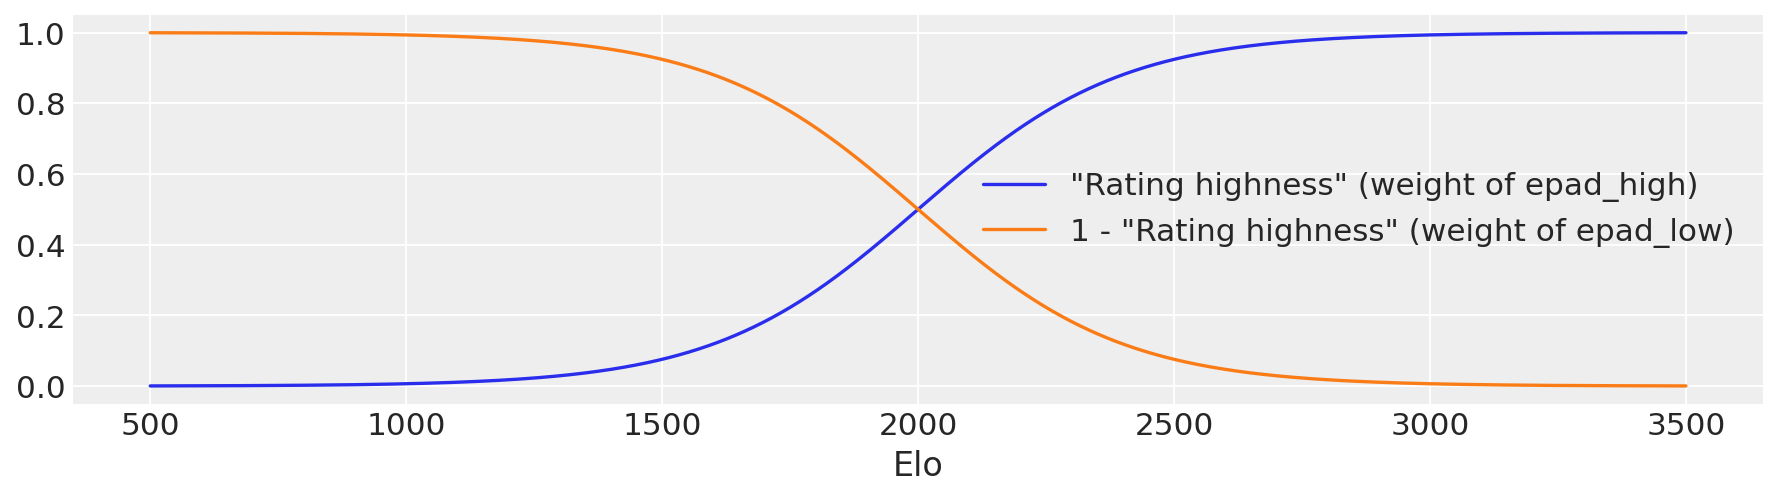

In [51]:
# |column: body-outset
x = np.linspace(500, 3500, 2000)
rh = eloHighness(jointBPSTAdjModel.idata, x)

fig, ax = plt.subplots(dpi=80, figsize=(11,3))
ax.plot(x, rh, label = '"Rating highness" (weight of epad_high)')
ax.plot(x, 1-rh, label = '1 - "Rating highness" (weight of epad_low)')
ax.set_xlabel('Elo')
ax.legend()
pass

Results for the joint models:

In [52]:
def set_xlims(axs):
    for _, ax in np.ndenumerate(axs):
        if ax != axs[0][0]:
            ax.set_xlim(-150,350)

    axs[0][0].set_xlim(-150,1100)

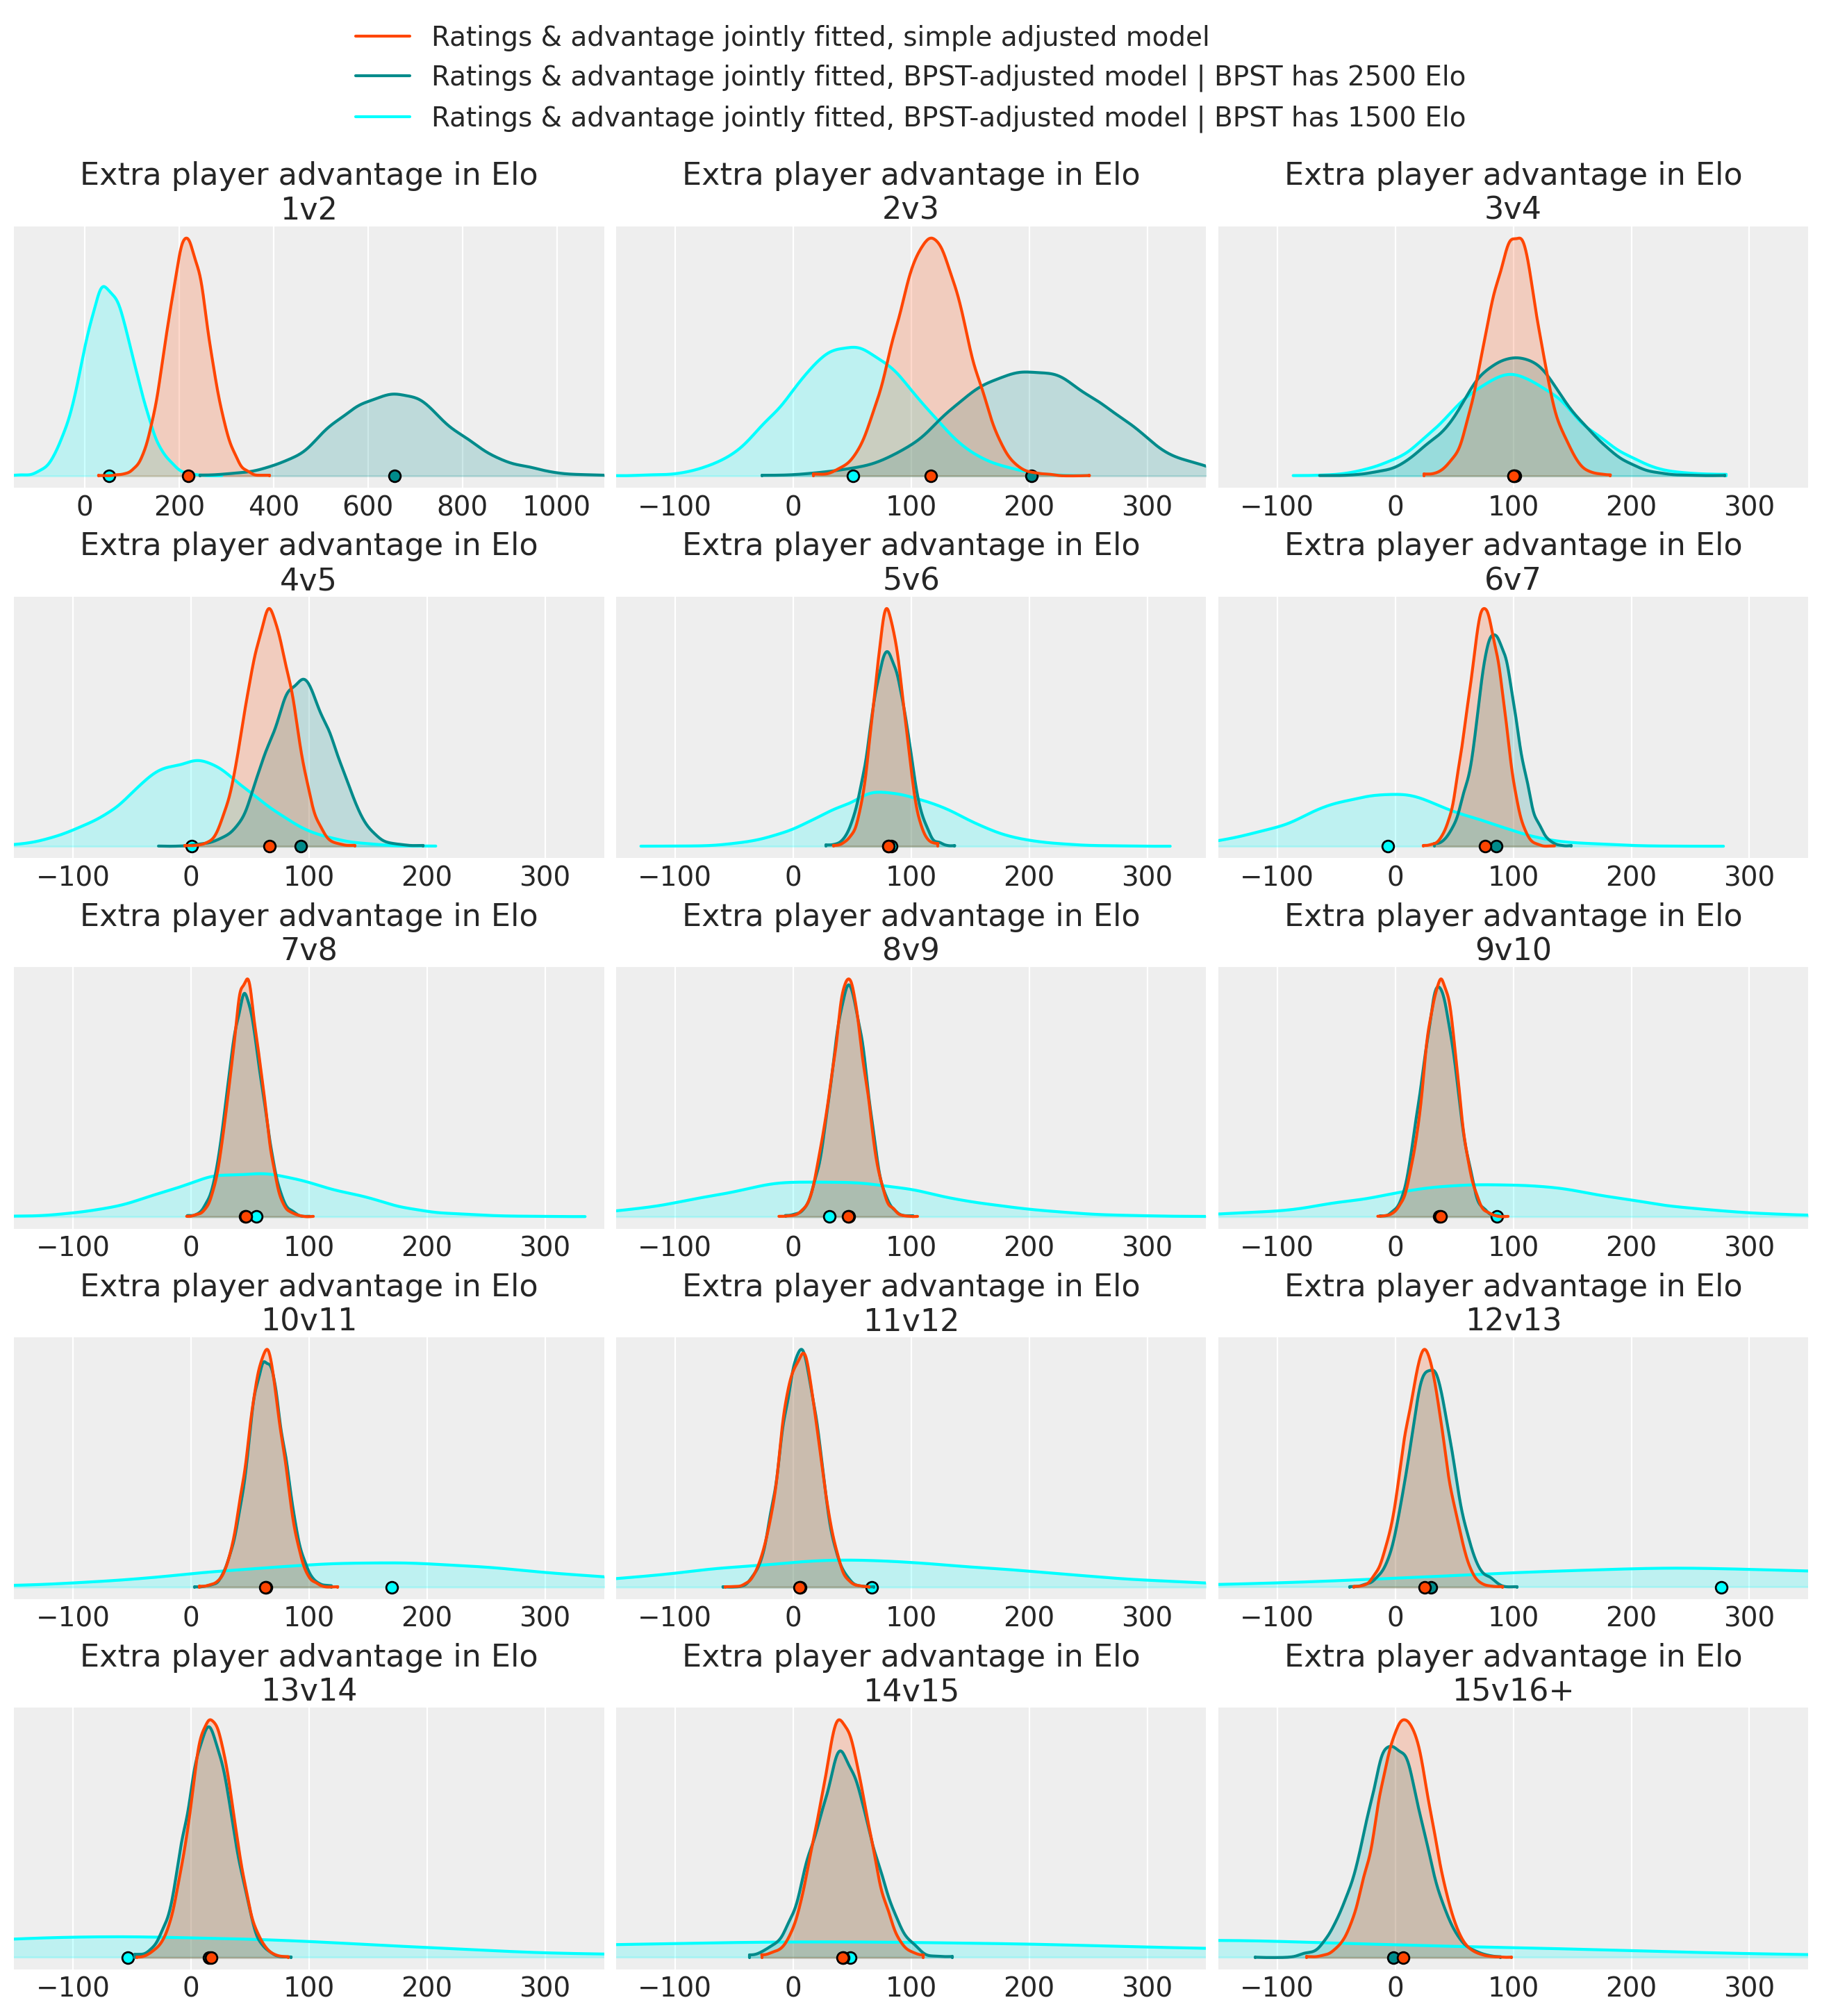

In [64]:
#| column: page
axs = az.plot_density(
    [jointBPSTAdjModel.epad_in_Elo(1500), jointBPSTAdjModel.epad_in_Elo(2500), jointSimpleAdjModel.epad_in_Elo()],
    data_labels=[jointBPSTAdjModel.title() + ' | BPST has 1500 Elo', jointBPSTAdjModel.title() + ' | BPST has 2500 Elo', jointSimpleAdjModel.title()],
    hdi_prob=1,
    figsize=(13,13.33),
    shade=0.2,
    point_estimate='mean',
    colors=['cyan','darkcyan', 'orangered']
)

whr.postprocess.putLegendOnTopOfFigure(axs[0][0], (.5,1.084))
set_xlims(axs)


Looking at the [game count table](#fig-game-counts), the large uncertainty for the 2500 Elo player in 1v2, and for the 1500 Elo player in 8v9 and bigger are probably due to insufficient sample size. Naturally, the larger the team, the higher-rated its best player tends to be.

In 3v4, and 5v6, the means of all three conditions are oddly close together.

For 1v2, 2v3, 4v5 and 6v7, the effect is susprisingly *larger* if the BPST is high-rated. This means that, say, [2500, 2100] vs [2700, 2100, 2100] (both averages = 2300) is supposedly more in favor of the large team than a similar game shifted down 1000 Elo ([1500, 1100] vs [1700, 1100, 1100]) is. I don't have an explanation for any of this.

Results for the fixed-rating models:

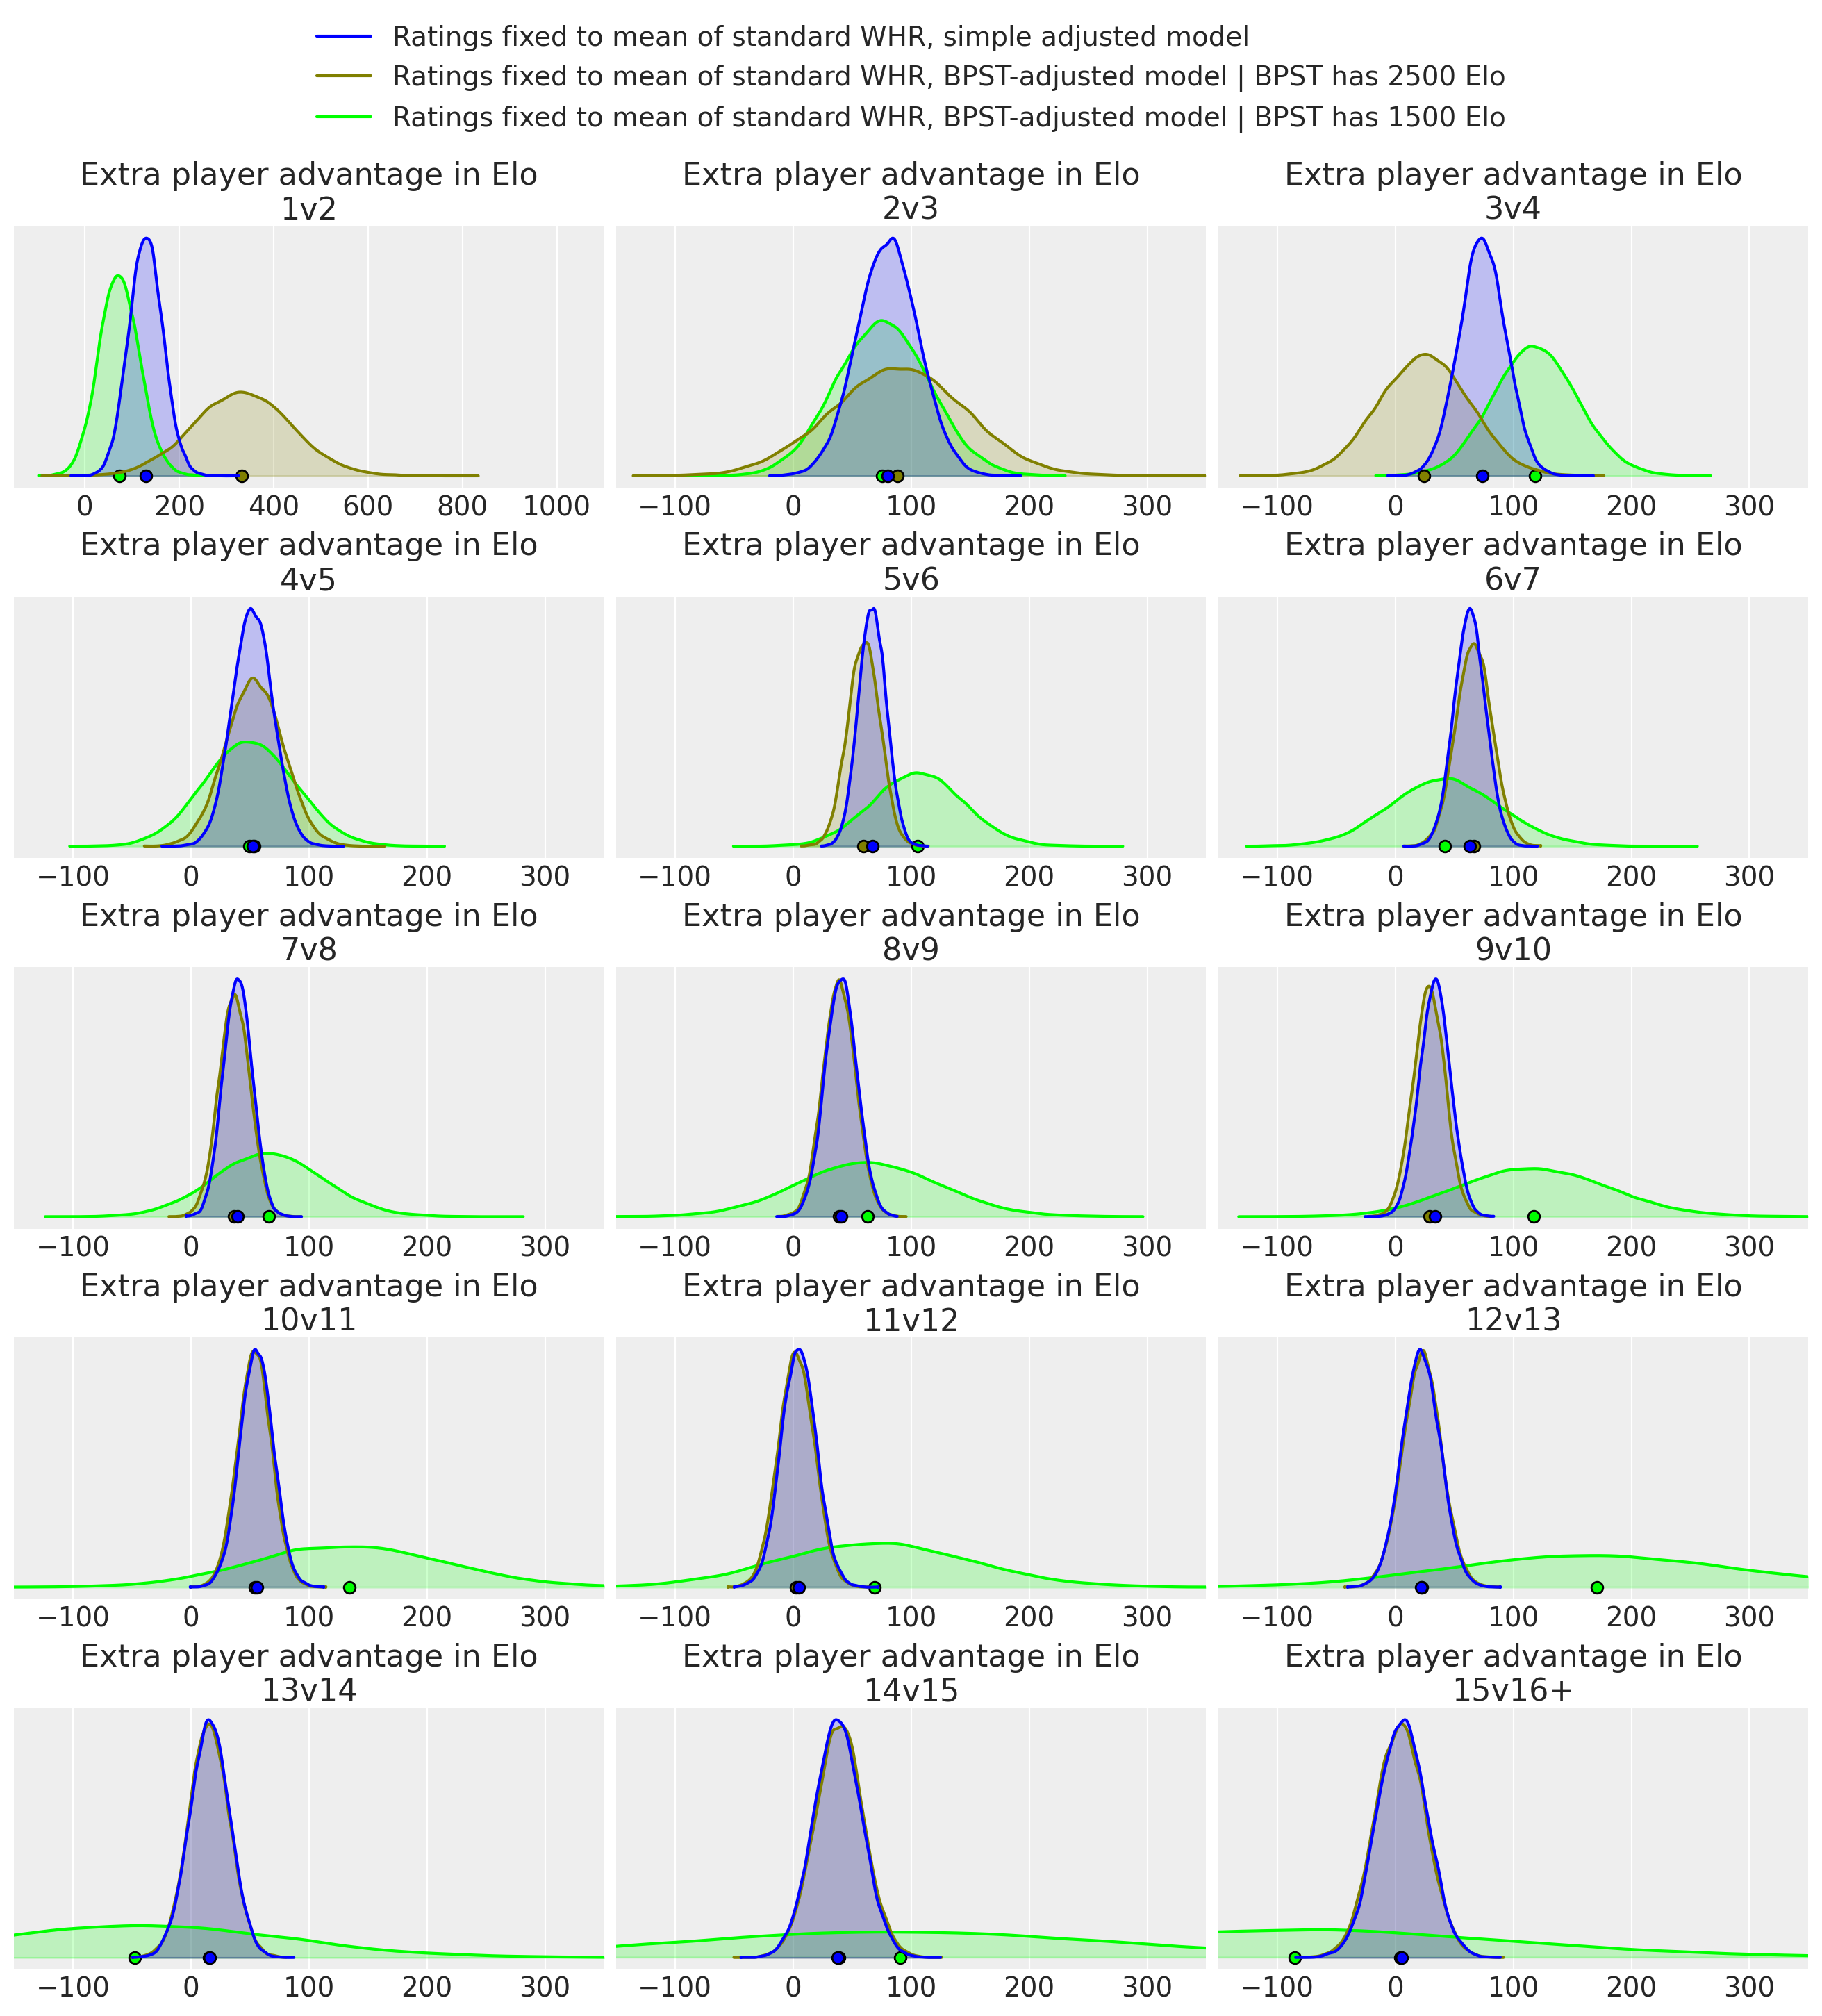

In [65]:
#| column: page
meanSimp = frModels['meanSimple']
meanBPST = frModels['meanBPST']

axs = az.plot_density(
    [meanBPST.epad_in_Elo(1500), meanBPST.epad_in_Elo(2500), meanSimp.epad_in_Elo()],
    data_labels=[meanBPST.title() + ' | BPST has 1500 Elo', meanBPST.title() + ' | BPST has 2500 Elo', meanSimp.title()],
    hdi_prob=1,
    figsize=(13,13.33),
    shade=0.2,
    point_estimate='mean',
    colors = ['lime','olive','blue']
)

whr.postprocess.putLegendOnTopOfFigure(axs[0][0], (.5,1.084))

set_xlims(axs)

Again a bit weird.


## Joint models vs fixed-ratings models

I tried each of the models with two different approaches:

Joint models
: Simultaneously infer both `epad` and the ratings of the players; both are parameters in the same model.


Fixed-rating models
: Infer the ratings using the unadjusted model. Take either the posterior mean or the MAP player ratings and use these as fixed ratings in a second model whose only parameters are the `epad`s.

One could argue that the joint models are the more relevant ones if we want to use the `epad` both for balancing and for determining ratings, and the fixed models are more relevant if we want to use `epad` only for balancing. In the former case, assuming `epad` is found to be positive, players on the smaller team will gain more / lose less Elo on win / loss than they otherwise would.

In any case, the advantage of the fixed models is much faster development iteration; the sampling of the joint models took about 6 hours each and the resulting traces are ~5 GB each.

Concerning the fixed models, the difference between fixing to mean or MAP was minimal (but the MAP does not require sampling and takes just seconds to compute; the full posterior over which the mean is taken takes hours as mentioned):

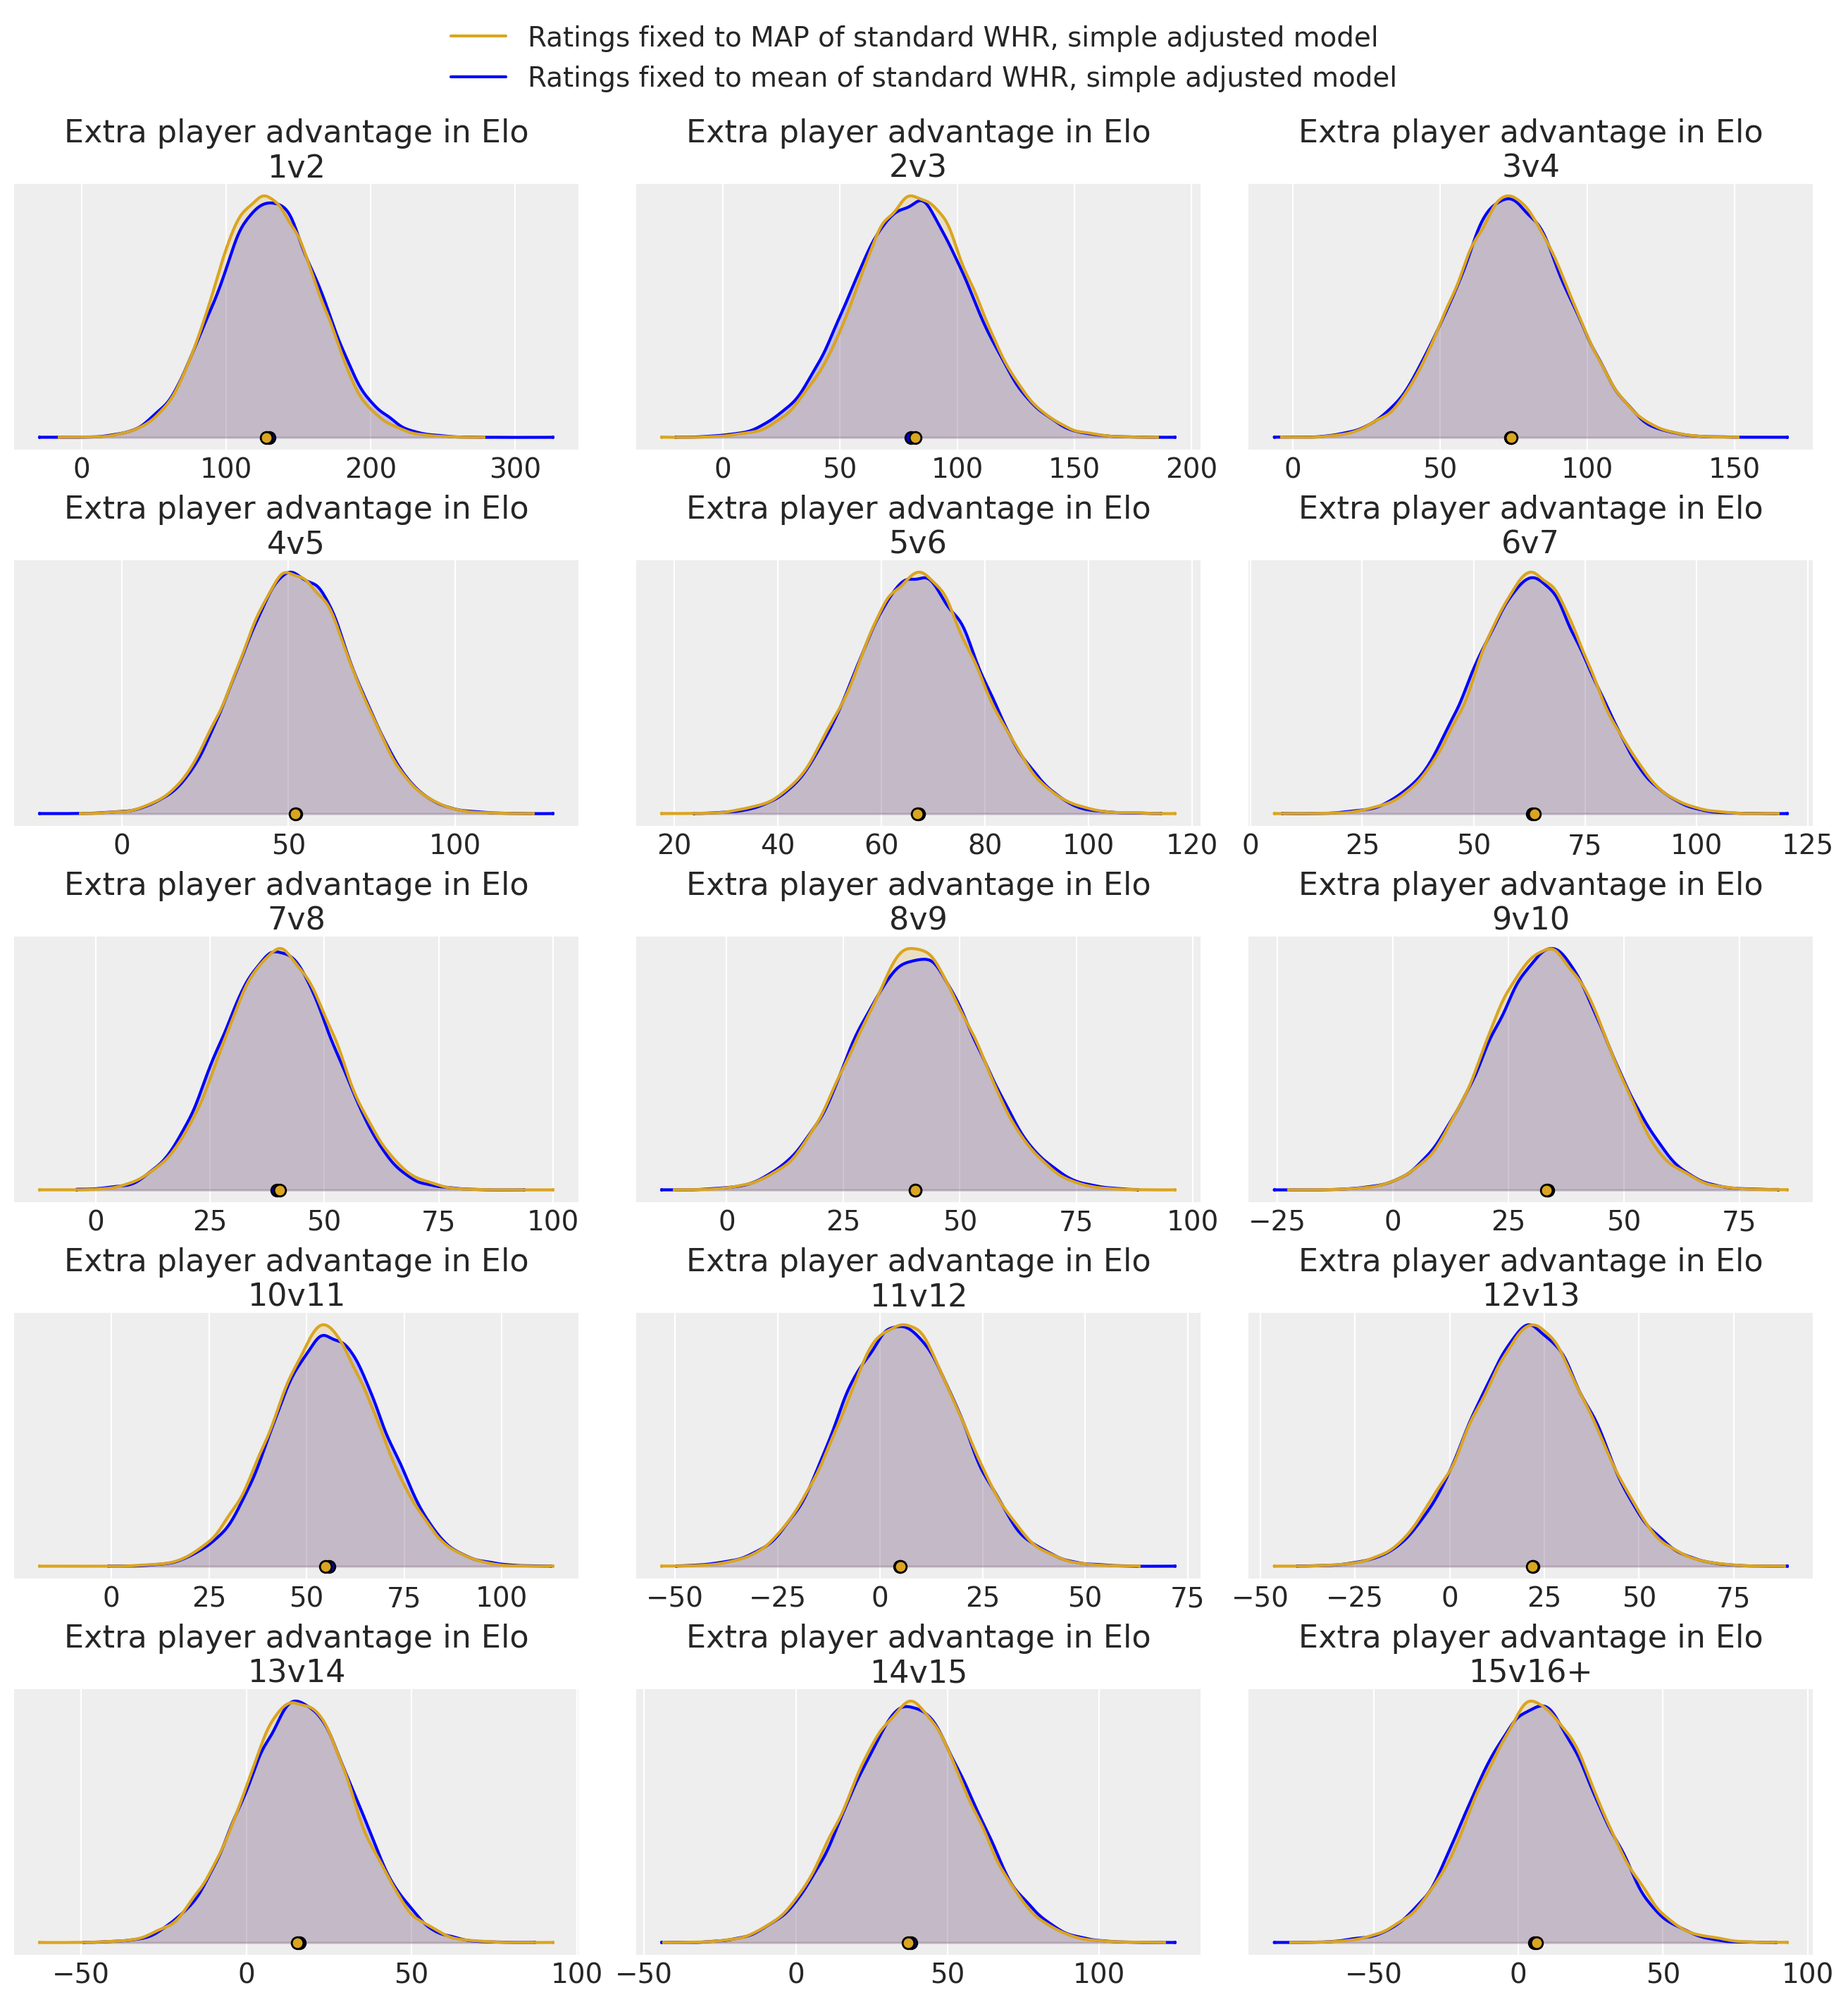

In [67]:
#| column: page
#| fig-cap: "Fixing ratings to mean vs MAP; autoscaled x-axes here so they all look similar"
axs = az.plot_density(
    [frModels['meanSimple'].epad_in_Elo(), frModels['mapSimple'].epad_in_Elo()],
    data_labels=titles([frModels['meanSimple'], frModels['mapSimple']]),
    hdi_prob=1,
    figsize=(13,13.35),
    shade=0.2,
    point_estimate='mean',
    colors=['blue','goldenrod']
)

whr.postprocess.putLegendOnTopOfFigure(axs[0][0], (.5,1.0598))

# for _, ax in np.ndenumerate(axs):
#     if ax != axs[0][0]:
#         ax.set_xlim(0,200)

## Model comparison

To estimate the out-of-sample predictive performance of the different models, I used something called PSIS-LOO, which is some very clever method for estimating the Leave-One-Out cross-validation performance (i.e. withholding one datapoint, training the model on all the others, then trying to predict the withheld point) for all the datapoints (games) without actually refitting the model N times.



### Joint models

In [ ]:
compareModels = { m.title() : m.idata for m in jointModels.values() }
cmp = az.compare(compareModels, ic='loo', var_name='Game outcomes')

In [69]:
#| column: page
cmp

rank      elpd_loo  \
Ratings & advantage jointly fitted, simple adju...     0 -16919.931164   
Ratings & advantage jointly fitted, BPST-adjust...     1 -16922.906608   
Unadjusted WHR model                                   2 -16995.340457   

                                                          p_loo  elpd_diff  \
Ratings & advantage jointly fitted, simple adju...  2341.398911   0.000000   
Ratings & advantage jointly fitted, BPST-adjust...  2356.170537   2.975444   
Unadjusted WHR model                                2332.351168  75.409293   

                                                      weight         se  \
Ratings & advantage jointly fitted, simple adju...  0.405117  52.663309   
Ratings & advantage jointly fitted, BPST-adjust...  0.428654  52.699955   
Unadjusted WHR model                                0.166229  51.029220   

                                                          dse  warning scale  
Ratings & advantage jointly fitted, simple adju...   0.000000     True   log  
Ratings & advantage jointly fitted, BPST-adjust...   6.763360     True   log  
Unadjusted WHR model                                15.056987     True   log

The meaning of these columns is documented [here](https://python.arviz.org/en/stable/api/generated/arviz.compare.html#arviz-compare), but the main point is also expressed in this chart:

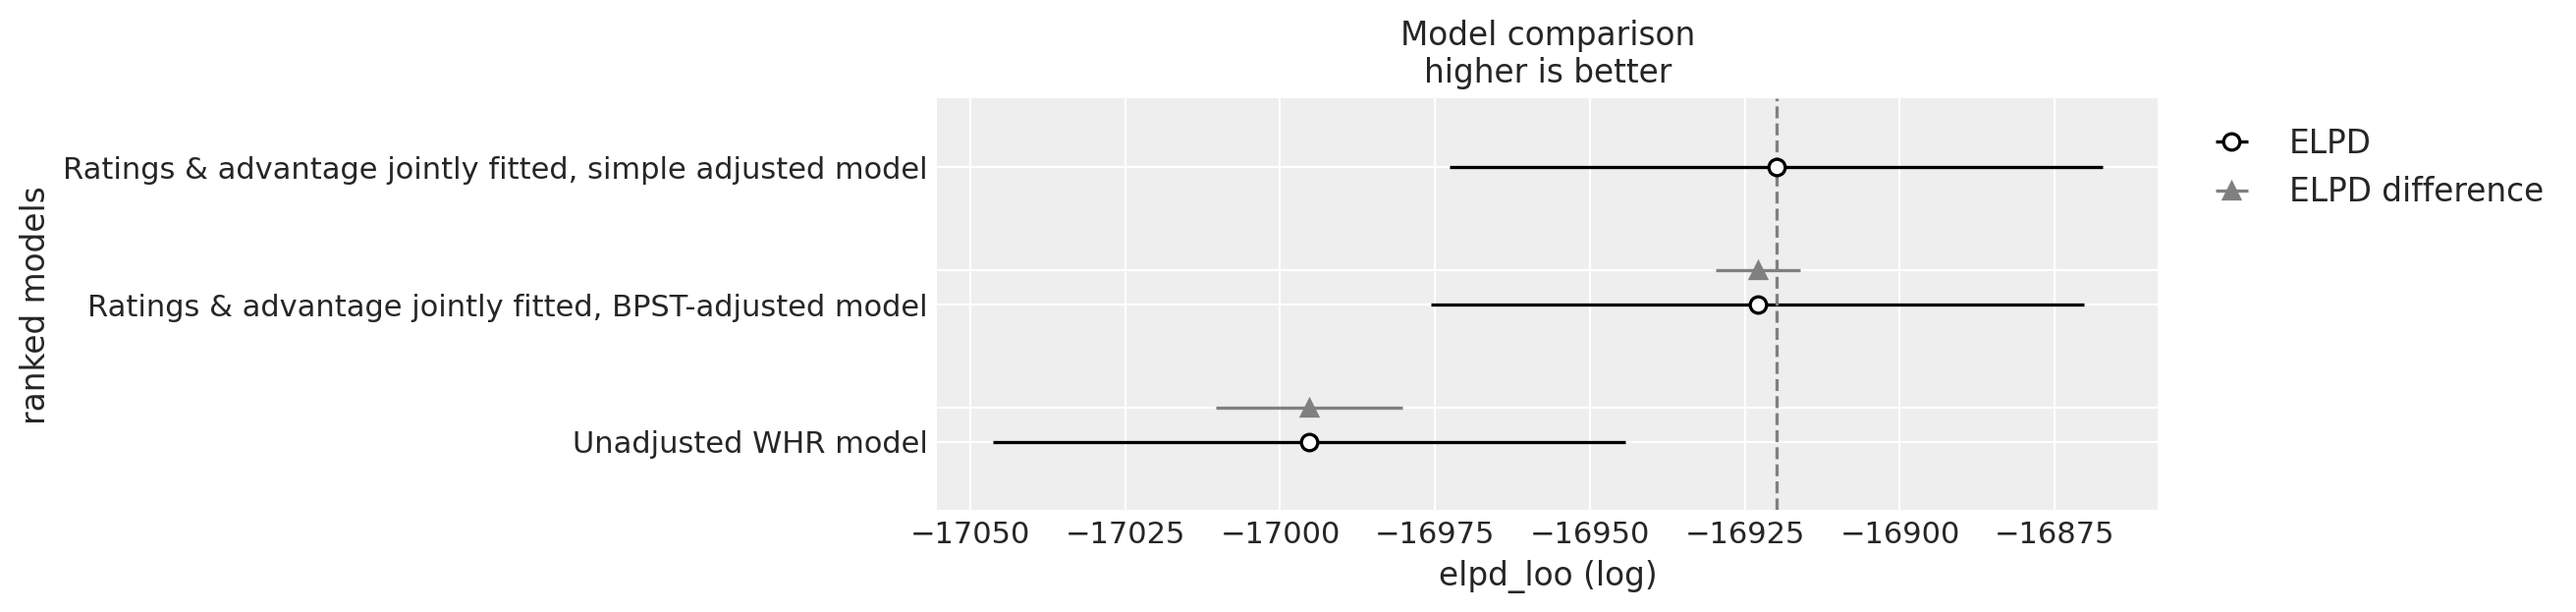

In [71]:
#| column: page
import warnings
_ = az.plot_compare(cmp, insample_dev=False, figsize=(13,3), textsize=11)

The simple adjusted model scores very slightly higher than the BPST-adjusted model (well within the margin of error), but both are clearly better than the unadjusted model.

### Fixed-rating models

The unadjusted fixed-rating models would have 0 parameters, which the library didn't like, so I kept the `epad` parameters but forced its value to be tiny (+- 1 Elo) for the "unadjusted".

In [72]:
compareModels = { m.title() : m.idata for m in frModels.values() }
cmp = az.compare(compareModels, ic='loo', var_name='Game outcomes')

In [73]:
#| column: page
cmp

rank     elpd_loo  \
Ratings fixed to mean of standard WHR, simple a...     0 -4834.600572   
Ratings fixed to mean of standard WHR, BPST-adj...     1 -4842.289611   
Ratings fixed to MAP of standard WHR, simple ad...     2 -4892.422248   
Ratings fixed to mean of standard WHR, unadjust...     3 -4896.855404   
Ratings fixed to MAP of standard WHR, BPST-adju...     4 -4899.837930   
Ratings fixed to MAP of standard WHR, unadjuste...     5 -4956.246161   

                                                        p_loo   elpd_diff  \
Ratings fixed to mean of standard WHR, simple a...  13.287767    0.000000   
Ratings fixed to mean of standard WHR, BPST-adj...  27.330235    7.689039   
Ratings fixed to MAP of standard WHR, simple ad...  13.315910   57.821676   
Ratings fixed to mean of standard WHR, unadjust...   0.017551   62.254832   
Ratings fixed to MAP of standard WHR, BPST-adju...  27.288016   65.237358   
Ratings fixed to MAP of standard WHR, unadjuste...   0.017789  121.645590   

                                                          weight         se  \
Ratings fixed to mean of standard WHR, simple a...  9.471064e-01  23.369459   
Ratings fixed to mean of standard WHR, BPST-adj...  1.794080e-02  23.567459   
Ratings fixed to MAP of standard WHR, simple ad...  6.826474e-12  21.752776   
Ratings fixed to mean of standard WHR, unadjust...  3.495283e-02  20.922578   
Ratings fixed to MAP of standard WHR, BPST-adju...  6.241311e-12  22.127098   
Ratings fixed to MAP of standard WHR, unadjuste...  0.000000e+00  18.869358   

                                                          dse  warning scale  
Ratings fixed to mean of standard WHR, simple a...   0.000000    False   log  
Ratings fixed to mean of standard WHR, BPST-adj...   3.925473    False   log  
Ratings fixed to MAP of standard WHR, simple ad...   2.426266    False   log  
Ratings fixed to mean of standard WHR, unadjust...  11.506776    False   log  
Ratings fixed to MAP of standard WHR, BPST-adju...   4.710803    False   log  
Ratings fixed to MAP of standard WHR, unadjuste...  11.593525    False   log

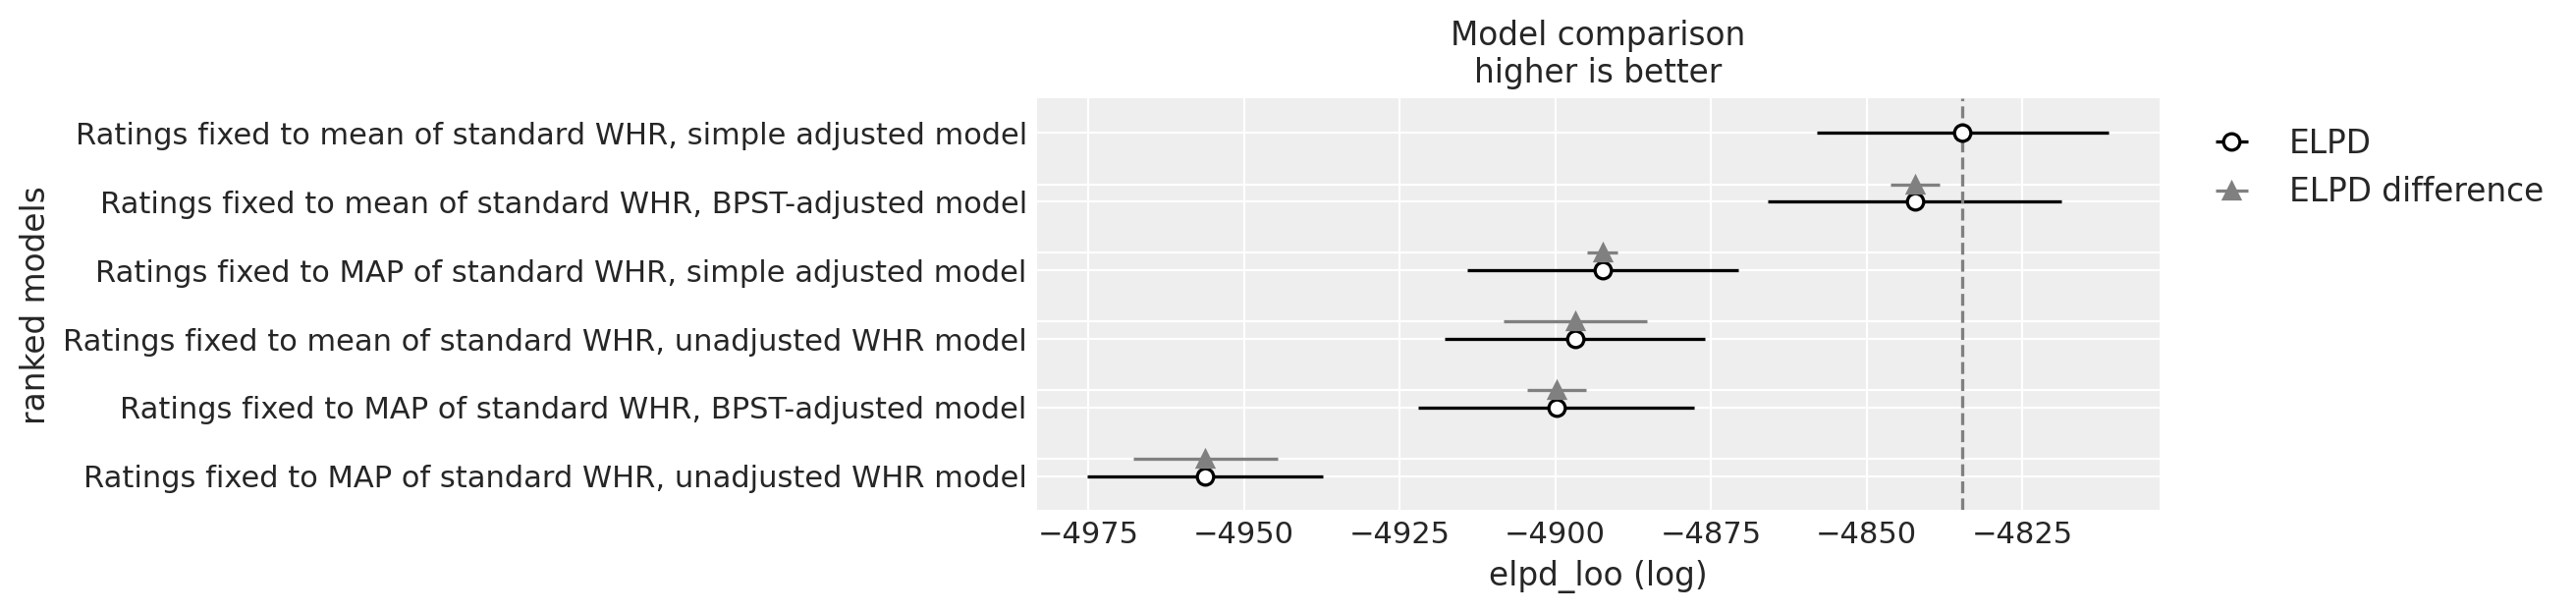

In [74]:
#| column: page
_ = az.plot_compare(cmp, insample_dev=False, figsize=(13,3), textsize=11)

Similar situation, except this time the simple model is a bit more ahead. Also, the mean ratings appear to be more predictive of game outcomes than MAP ratings (despite producing virtually the same `epad` estiamtes), idk.

The scores of the joint models and the fixed-rating models are uncomparable because the former try to predict all games in the dataset while the latter only look at the uneven-sized games.

Due to the somewhat erratic results with the BPST models (pointing to possible implementation error) and the similar PSIS-LOO scores, I went with the simple models as the "main result".


# Implementation

The models were implemented using the Python library [PyMC](https://www.pymc.io/) and the results analyzed using [ArviZ](https://python.arviz.org/). Samples from the posterior were taken using the NUTS sampler (No U-Turn Sampler, a type of Hamiltonian Monte Carlo sampler, where in my very basic understanding, you reinterpret your posterior density function as a physical potential and let a thermal particle bounce around in it.)

The parameters of the implemented model are technically not the ratings, but the *increments* of the ratings from day to day, in addition to the first-day rating (rating increments are much less correlated than ratings; making the ratings be parameters directly caused incredibly slow sampling).

Summing up the increments to get ratings was tough to optimize because different players have different numbers of days played, but vectorized functions such as `cumsum` expect to sum equally many numbers in each batch. Tried a bunch of things, but in the end went with a sparse matrix (containing only 0s and 1s) to turn the increments into ratings.

I took 8000 samples for each of the joint models and 32k for the fixed-rating ones:

In [75]:
#| column: page
def getSamplingParams(m : WHRModel):
    sst = m.idata.sample_stats
    return pd.Series(dict( \
        model = m.title(),
        chains = len(sst.coords['chain']),
        draws_per_chain = len(sst.coords['draw']),
        tuning_steps_per_chain = sst.attrs['tuning_steps'],
        sampling_time = sst.attrs['sampling_time'] 
        ))

pd.DataFrame([getSamplingParams(m) for m in iter.chain(jointModels.values(), frModels.values())])
# jointModels['jointUnadjModel'].idata.sample_stats

model  chains  draws_per_chain  \
0                               Unadjusted WHR model       4             2000   
1  Ratings & advantage jointly fitted, simple adj...       4             2000   
2  Ratings & advantage jointly fitted, BPST-adjus...       4             2000   
3  Ratings fixed to mean of standard WHR, unadjus...      16             2000   
4  Ratings fixed to mean of standard WHR, simple ...      16             2000   
5  Ratings fixed to mean of standard WHR, BPST-ad...      16             2000   
6  Ratings fixed to MAP of standard WHR, unadjust...      16             2000   
7  Ratings fixed to MAP of standard WHR, simple a...      16             2000   
8  Ratings fixed to MAP of standard WHR, BPST-adj...      16             2000   

   tuning_steps_per_chain  sampling_time  
0                    1000   21949.181222  
1                    1000   22125.382339  
2                    1000   24227.251962  
3                    1000      19.385246  
4                    1000      18.501285  
5                    1000      29.026480  
6                    1000      20.603636  
7                    1000      20.173541  
8                    1000      31.721375

# Background {#sec-bg}
## Bayes

WHR is a Bayesian model, as are the extensions of it in this post. Bayesianism interprets probabilities as [representing a state of knowledge or as quantification of a personal belief.](https://en.wikipedia.org/wiki/Bayesian_probability). So you can say something like "I think there's a 20% probability that Krow will be buffed in ZK 1.11.7" even though this is not a repeatable process such as throwing dice, in which case "20%" would represent the long-run average frequency.

In Bayesian inference, we are interested in the values of some unknown parameters (in WHR: The unobservable true rating of each player for each day, and here also the size of the extra player advantage) and start by formulating our belief (before having seen the data) about what the values of the parameters could possibly be; this probability distribution is called the prior (see [below](#sec-whr-prior) for WHR's prior). We also need to specify a likelihood function, which states the probability of making some specific observation (here: game outcome) if the unknown parameters had some particular value.

Given the prior, the likelihood, and the data/evidence, we can use [Bayes' theorem](https://en.wikipedia.org/wiki/Bayesian_inference#Formal_explanation) to "update" our belief about what the most likely values of the parameters are; the updated probability distribution is called the posterior.[The posterior is a probability distribution, but only a single rating value is shown in ZK; AFAIK, this is the value with the highest posterior probability density (also known as the MAP, maximum a posteriori).]{.aside}

## WHR's likelihood function {#sec-whr-like}

For WHR, the likelihood function is taken to be:

$$\text{Let } R := \text{team 1 Elo} - \text{team 2 Elo, then}$$
$$P(\text{team 1 wins} | R) = \frac{1}{1 + 10^\frac{-R}{400}}$$

Of course, the win chance converges to 1 as $R \to +\infty$, to 0 as $R \to -\infty$, and is 0.5 if $R=0$.


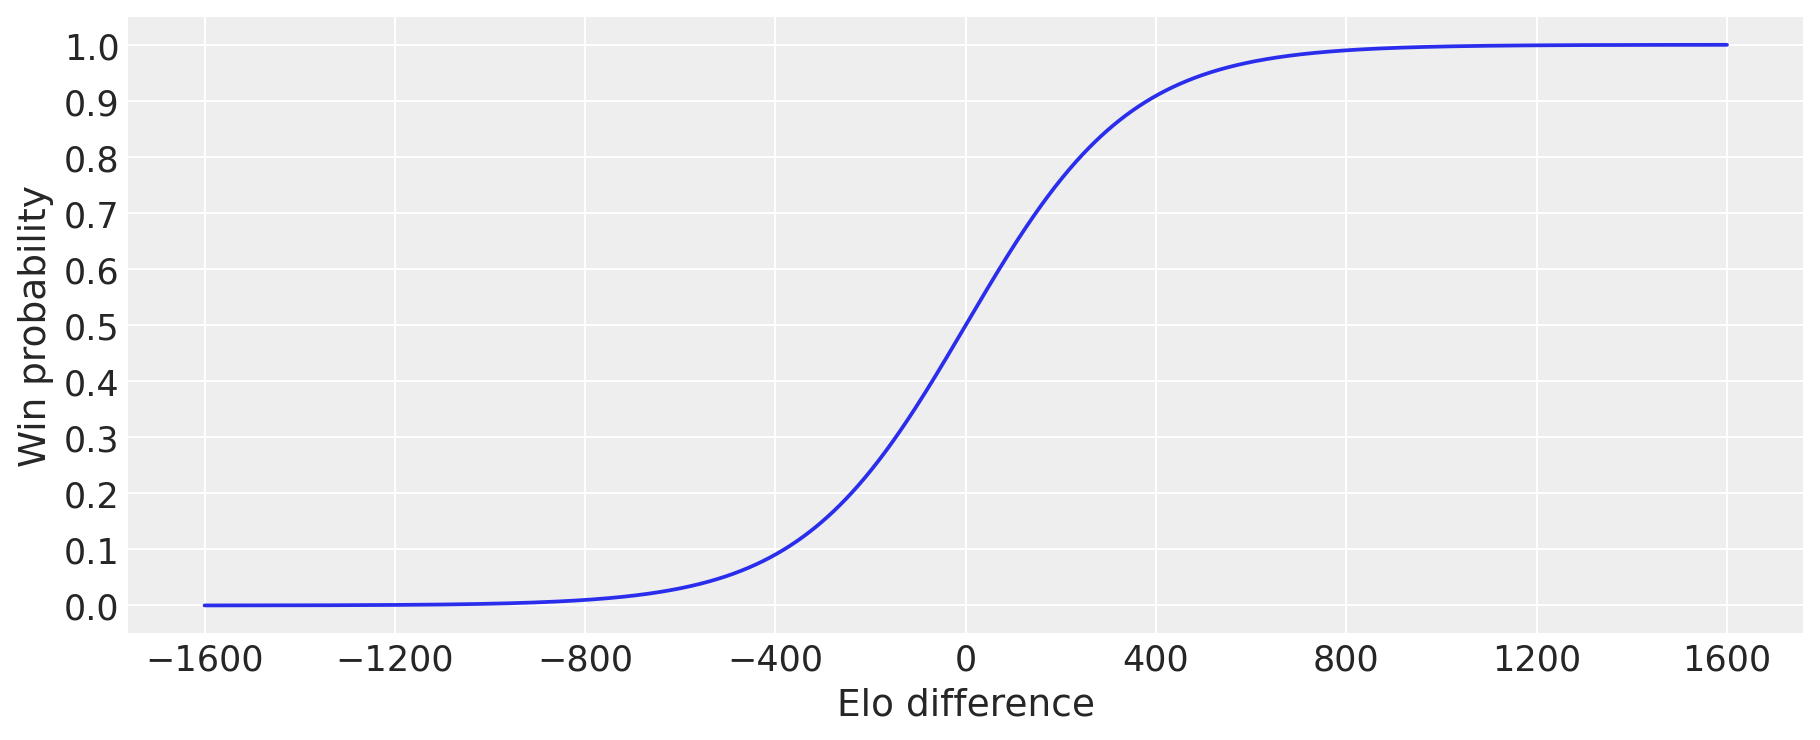

In [52]:
x=np.linspace(-1600,1600,2000)
ax : plt.Axes 
fig, ax = plt.subplots(dpi=90, figsize=(10,4))
ax.plot(x, 1/(1+np.exp(-whr.naturalRatingPerElo * x)))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_locator(plt.MultipleLocator(400))
ax.set_ylabel('Win probability')
ax.set_xlabel('Elo difference')
pass

It is mathematically convenient to measure the ratings on a scale called "natural rating"[^naturalRating] instead of Elo, where $$\text{1 natural rating} = \frac{400}{\ln(10)}\text{ Elo} \approx 174 \text{ Elo}$$

[^naturalRating]: The origin of the scale is also shifted; 0 natural rating corresponds to 1500 Elo (this is like degree C vs F for temperature), but this doesn't matter when only computing the difference of two ratings. The *only* place where we aren't just looking at differences is in the fictional win and loss on the first day vs. a 1500 Elo = 0 natural rating player. 
$$\text{A difference of r natural rating units} = \text{a difference of } \frac{400 r}{\ln(10)} \text{Elo}$$
$$r \text{ natural rating (absolute) } = 1500 + \frac{400 r}{\ln(10)} \text{Elo (absolute)}$$ 

Then the likelihood is just the standard logistic aka sigmoid function:

$$\text{Let } r := \text{team 1 natural rating} - \text{team 2 natural rating, then}$$
$$P(\text{team 1 wins} | r) = \frac{1}{1 + \exp(-r)} =: \operatorname{sigmoid}(r)$$

Team ratings are averaged:

$$\text{Team 1 rating} = \text{average of the ratings of the players on team 1}$$
$$\text{Team 2 rating} = \text{average of the ratings of the players on team 2}$$


## WHR's prior {#sec-whr-prior}

### First day rating
The prior used by WHR for the first-day rating of a new player is induced by assuming that the player had one fictional win and one fictional loss against a virtual 1500 Elo (0 natural rating) player. Since this is already a virtual Bayesian update, it raises the question of what the "prior of the prior" is, which I couldn't find answered in the paper, but is presumably a flat improper prior. For implementation convenience, I used a broad normal distribution (sigma = 2000 Elo) instead of the flat prior, but the difference should be minimal.

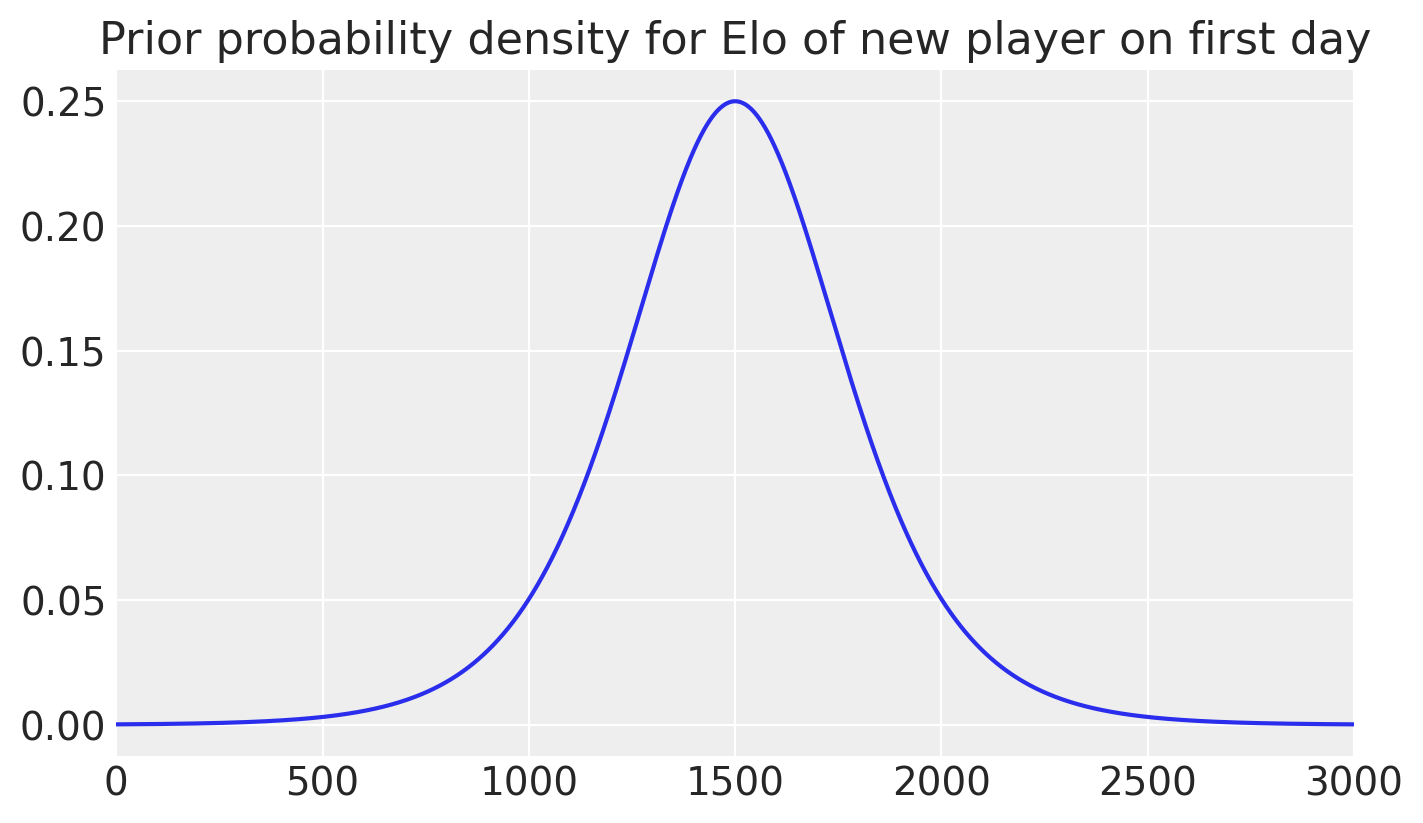

In [98]:
fig = plt.figure(figsize=(7,4))
x_elo = np.linspace(0,3000,2000)
firstDayPrior = 1/(1+np.exp(-whr.eloToNaturalRating(x_elo))) * 1/(1+np.exp(whr.eloToNaturalRating(x_elo)))
# fig, [ax1, ax2] = plt.subplots(1,2)
ax1 = fig.add_subplot()
ax1.plot(x_elo, firstDayPrior)
ax1.set_xlim(0,3000)
ax1.set_title('Prior probability density for Elo of new player on first day')

# ax2.plot(x_elo, firstDayPrior)
# ax2.set_yscale('log')
pass

### Rating change between days
The prior used by Zero-K-WHR for the rating *change* of a player from one day to the next is a normal distribution with variance equal to:
$$ \text{rating change of player P from day } d_1 \text{ to } d_2 \sim \text{Normal}(0, \sigma),$$
$$ \sigma^2  = w \cdot 500 \text{ Elo}^2 + (d_2 - d_1) V \text{ Elo}^2$$
where
$$w := \text{weight of games P played on } d_2$$
$$\text{where "weight" of a game = } \frac{1}{\text{number of players on P's team}}$$
$$(\text{so 1 for 1v1, } \frac{1}{2} \text{for 2v2 etc.)}$$
$$W := \text{total weight of all games P played up to } d_1$$
$$V := \frac{200000}{W + 400}$$ 

The last part means that a new player starts out with a variance of $\frac{200000}{400} = 500$ square Elo per day, but the variance per day slowly decreases to zero as they play more games. The additional variance per game weight remains constant though.

These constants are defined [here](https://github.com/ZeroK-RTS/Zero-K-Infrastructure/blob/7e8374e233a593208311f85a79cf6926cf4bb58f/Shared/PlasmaShared/GlobalConst.cs#L128).

Some example values for the standard deviation of the prior of rating change from day $d_1$ to $d_2$ for a player with W = 100 (that is 100 1v1s or 1000 10v10s played in total):

In [78]:
#| column: body
days=[1,10,100]
weights=[0.1, 0.3, 1, 3, 10, 30]
W=100

df = pd.MultiIndex.from_product([days,weights], names=['d','w']).to_frame().assign(sd = lambda df: \
    np.sqrt(df.w * whr.zkNaturalRatingVariancePerGame + df.d * whr.zkNaturalRatingVariancePerDay(W)) * whr.eloPerNaturalRating)[['sd']] \
        .unstack('d') \
        .rename(columns = dict(sd = 'σ [Elo]'))

df.columns.rename([None, 'd2 - d1: Days since last game -->'], inplace=True)
df.index.rename('w : Weight of games played on day d2', inplace=True)

df.Name = 'foo'

with pd.option_context('display.multi_sparse', False):
    display(HTML(df.round(1).to_html()))

WHR is assuming that the skill of a player *probably* doesn't change a huge amount in a short time and with few games played. It can be convinced of the opposite though, given strong enough evidence.

As an example for the importance of the prior for rating changes, consider a player who won all their games yesterday and lost all their games today. The maximum likelihood explanation would be that their rating was $+\infty$ (or the maximum technically allowed rating) yesterday and $-\infty$ today. This would make the likelihood of the observations 100%. But the prior says that player skill does generally not change that quickly, and in the end the assigned rating is a compromise between likelihood and prior probability. Their rating was higher yesterday than today, but not so extremely.

From a design perspective, these priors could be modified to achieve some desired goal (such as slower or faster rating changes) while staying within the same Bayesian framework.

# Top 100

As a sort of plausibility check, here are the Top 100 sorted by the posterior mean of rating in the unadjusted model (only last available day for each player). It's unsurprising that there's little change in Elo in the adjusted models, since frequent players should have no systematic tendency to be either on the smaller or the larger team, so the Elo gained/lost from the adjustment for being in the small/large team should cancel out.

Thin lines are 95% highest density intervals, thick lines are interquartile ranges.

In [79]:
def getLastRatings(m : WHRModel):
    rats = m.idata['posterior'].ratings.isel(playerDay = m.ratingIxLookup.groupby('player').tail(1))
    rats['playerDay'] = rats['playerDay'].str.strip(' 00:00:00', side='right')
    rats.name = 'Elo'
    return rats 

for m in jointModels.values():
    m.lastRatings = getLastRatings(m)

unadjMeans = jointModels['jointUnadjModel'].lastRatings.mean(dim=('chain','draw'))
plotDatas = [ m.lastRatings.sortby(unadjMeans, ascending=False).isel(playerDay=slice(100)).pipe(naturalRatingToElo)
                            for m in jointModels.values()]
plotDataTitles = [m.title() for m in jointModels.values()]

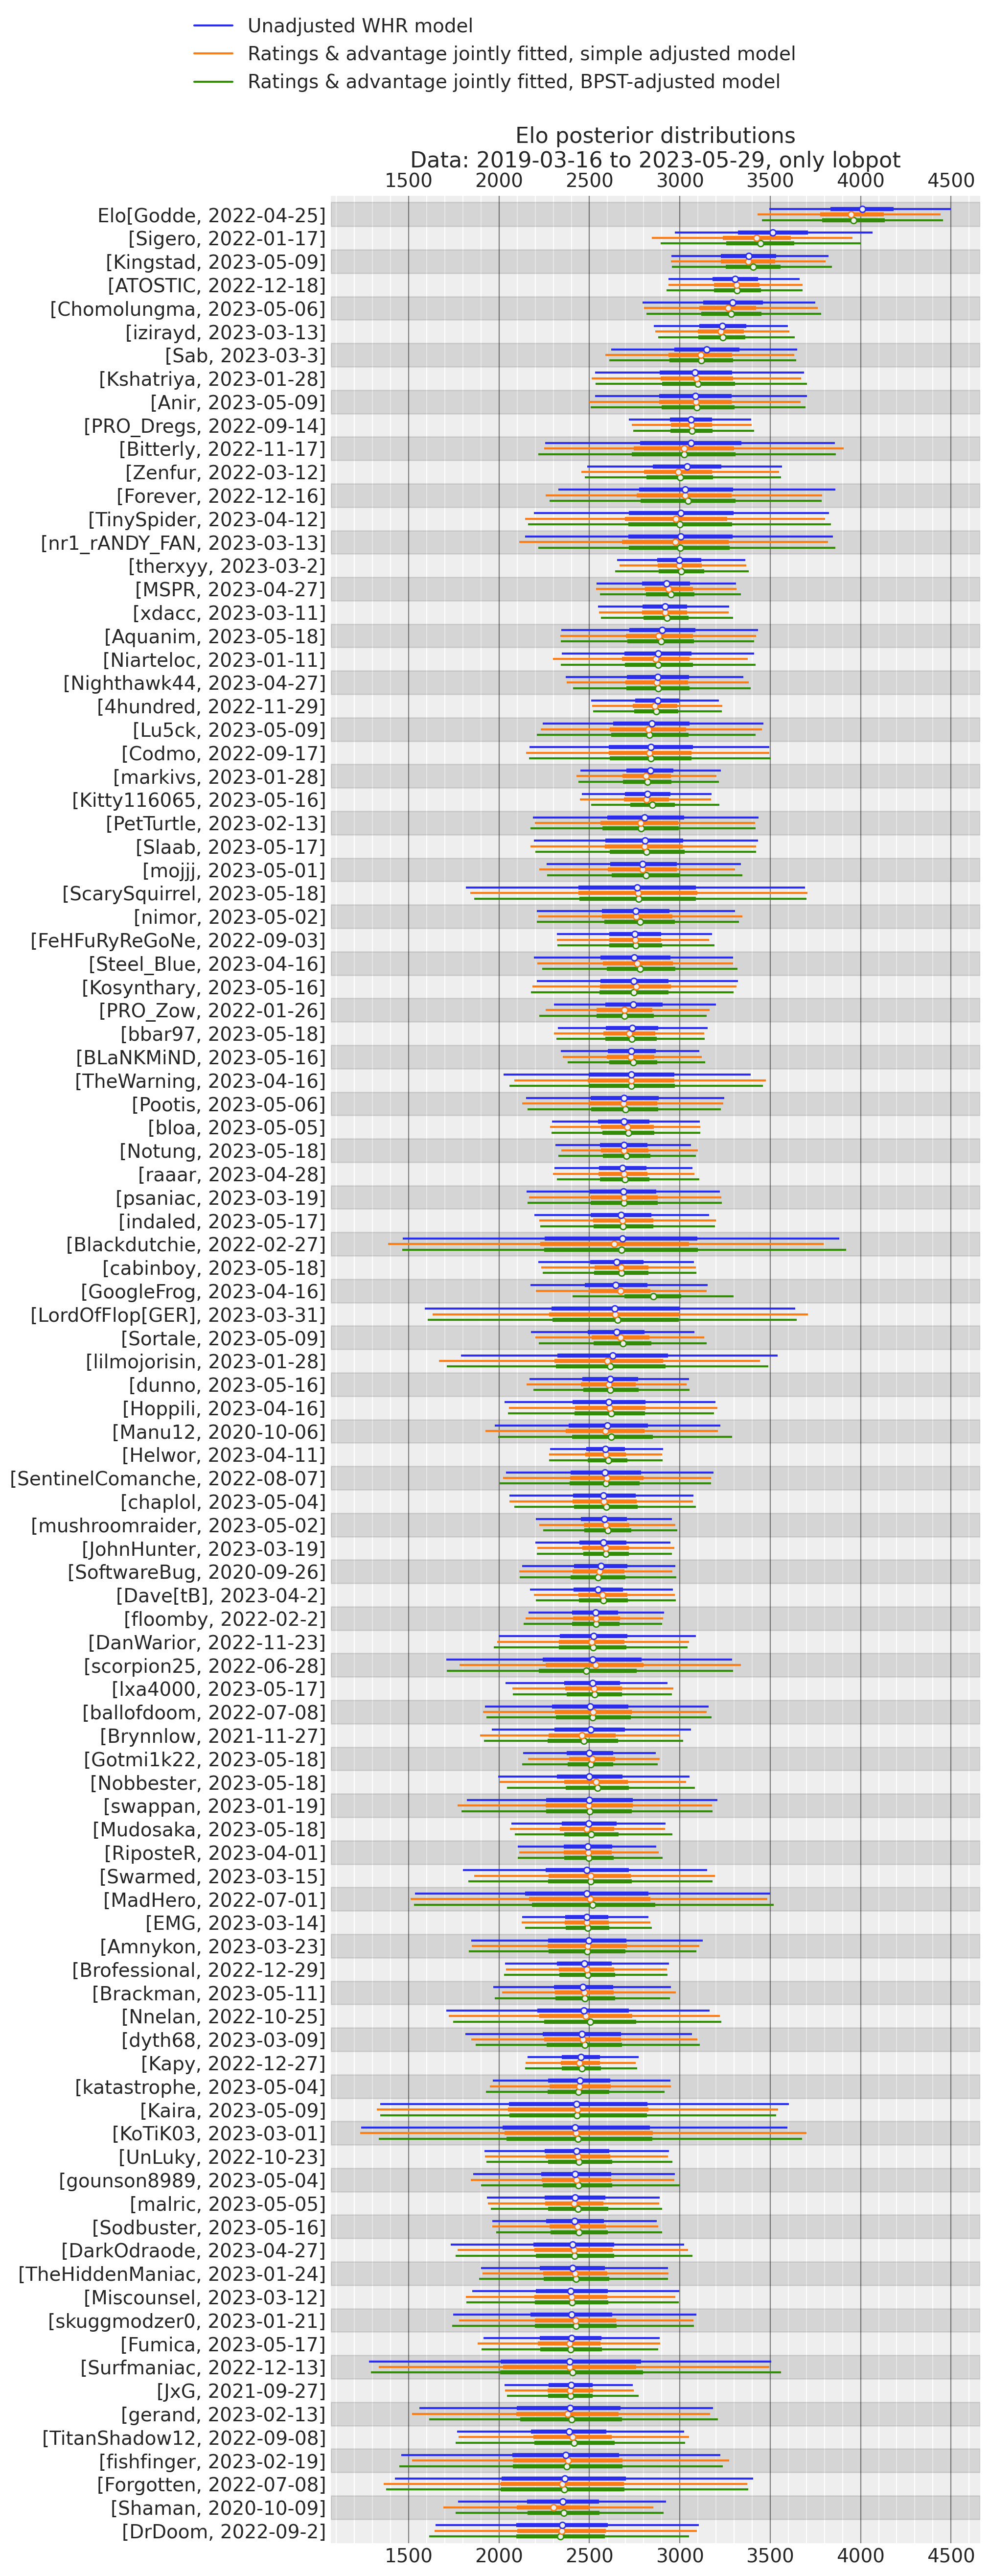

In [80]:
#| column: page
[ax] = az.plot_forest(plotDatas, model_names=plotDataTitles,
        combined=True, figsize=(10,25), hdi_prob=0.95)
plt.minorticks_on()
plt.grid(True,which='minor',axis='x')
plt.grid(True,which='major',color='grey',axis='x')
plt.title('Elo posterior distributions\nData: 2019-03-16 to 2023-05-29, only lobpot')
ax2 = ax.secondary_xaxis(location='top')
whr.postprocess.putLegendOnTopOfFigure(ax, bbox=(0.5,1.05))

# ypositions = np.array([t.get_position()[1] for t in ax.get_yticklabels()])
# xlim = ax.get_xlim()
# ax.hlines(ypositions + 0.5*(ypositions[1] - ypositions[0]), xlim[0], xlim[1], color='white',zorder=-10,linewidth=1)
# ax.legend(['95% highest density interval', 'Interquartile range', 'mean', 'foo', None, 'bar'])